<a href="https://colab.research.google.com/github/SXV357/Object_Detection/blob/main/Object_Detection_Section1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

print("TensorFlow version: {}".format(tf.__version__))

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)
  
  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)
  
  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# Helper functions

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)    
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels      
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)  
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry. 
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
  ax.legend(loc = 1)    
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')
  
  plt.show()

TensorFlow version: 2.8.2


In [2]:
#Loading in training and testing datasets
(x_train, y_train), (x_test, y_test) = load_vehicle_dataset()

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
#checking type and shape of labels training + testing dataset
print(f'Our labels are stored as {type(y_train)} in Python')
print(f'The label vector of the training set has dimensions of {y_train.shape}') # 15000 training labels
print(f'The label vector of the test set has dimensions of {y_test.shape}') # 3000 testing labels

Our labels are stored as <class 'numpy.ndarray'> in Python
The label vector of the training set has dimensions of (15000,)
The label vector of the test set has dimensions of (3000,)


In [4]:
for index, element in enumerate(idx_to_class):
  print(f'Class {index} contains {element} images')

Class 0 contains background images
Class 1 contains car images
Class 2 contains truck images


In [5]:
# checking number of images in each class
import collections

print(collections.Counter(y_train)) # tells how many images per class(5x more for training dataset than testing dataset)
print(collections.Counter(y_test))


Counter({0: 5000, 1: 5000, 2: 5000})
Counter({0: 1000, 1: 1000, 2: 1000})


In [6]:
print(x_train.shape) # 15,000 images with height = 32, width = 32 and 3 color spectrums
print(x_test.shape) # 3,000 images with height = 32, width = 32 and 3 color spectrums

(15000, 32, 32, 3)
(3000, 32, 32, 3)


Label: 0


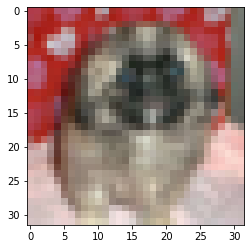

In [7]:
# plot a SINGLE image
plot_one_image(x_train, y_train, 1200) # 1st 5000 are background, next 5000 are cars, and last 5000 are trucks

In [9]:
# building a simple neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, MaxPooling2D, Convolution2D
from tensorflow.keras import optimizers

model = Sequential()
model.add(Dense(4, input_shape=(3,),activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

In [10]:
# building a 2-layer model
model_1 = Sequential()
model_1.add(Dense(4, input_shape=(3,),activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# checking to see if model works
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'softmax'))
model_1_answer.compile(loss='categorical_crossentropy',
optimizer = 'adam', 
metrics = ['accuracy'])

if model_to_string(model_1) == model_to_string(model_1_answer):
  print('Good job! Your model worked')
else: 
  print('Please check your code again!')

Good job! Your model worked


In [13]:
#building a custom 2-layer neural network using a multi-layer perceptron model

perceptron = Sequential()

perceptron.add(Convolution2D(64, 3, 3, input_shape = (32, 32, 3), activation = 'linear'))
perceptron.add(Flatten(input_shape = (32, 32, 3)))

perceptron.add(Dense(312, activation = 'relu'))
perceptron.add(Dense(256, activation = 'relu'))
perceptron.add(Dense(256, activation = 'linear'))
perceptron.add(Dropout(0.4))
perceptron.add(Dropout(0.25))
perceptron.add(Dense(3, activation = 'sigmoid'))

perceptron.compile(loss = 'categorical_crossentropy', 
                   optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
                   metrics = ['accuracy'])

# checking to see if model works

perceptron_answer = Sequential()
perceptron = perceptron_answer
perceptron_answer.add(Flatten(input_shape = (32, 32, 3)))
perceptron_answer.add(Dense(units = 128, activation = 'relu'))
perceptron_answer.add(Dense(units = 3, activation = 'softmax'))
    
perceptron_answer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
              metrics=['accuracy'])

if model_to_string(perceptron) == model_to_string(perceptron_answer):
  print('Good job, you specified it correctly!')
else: 
  print('Please check your code again!')


Good job, you specified it correctly!


In [14]:
#training perceptron on images from training data

from tensorflow.keras.callbacks import ModelCheckpoint

# define our monitor
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Normalize the data.
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

# Convert labels into one-hot numpy arrays.
y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)


perceptron.fit(x_train_norm, y_train_onehot)


469/469 [==============================] - 2s 3ms/step - loss: 0.8818 - accuracy: 0.6279


Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6732 - accuracy: 0.7185 - val_loss: 0.7146 - val_accuracy: 0.6970
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6002 - accuracy: 0.7581 - val_loss: 0.7110 - val_accuracy: 0.7070
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5529 - accuracy: 0.7793 - val_loss: 0.7197 - val_accuracy: 0.6990
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.5116 - accuracy: 0.7987 - val_loss: 0.6899 - val_accuracy: 0.7180
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4749 - accuracy: 0.8145 - val_loss: 0.7257 - val_accuracy: 0.7133
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4383 - accuracy: 0.8287 - val_loss: 0.7352 - val_accuracy: 0.7100
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4078 - accuracy: 0.8469 - val_loss: 0.7253 - val_accuracy: 0.7047
Epoch 

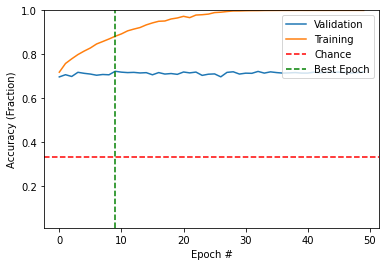

In [15]:
# plotting training vs testing accuracy of model

history = perceptron.fit(x_train_norm, y_train_onehot, epochs = 50, validation_data = (x_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])
plot_acc(history)